# Problem Understanding & Assumptions

    aims to predict the 15-day future price direction (UP/DOWN) of selected stocks using historical market data and machine learning.

# Assumptions

    Past price behavior contains predictive signals

    Markets show momentum, volatility clustering, and seasonality

    No transaction costs or slippage are considered

    Models are trained per ticker independently

    This cell initializes libraries, custom modules, and metrics required for a leakage-free time-series ML pipeline.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    ConfusionMatrixDisplay
)

# Add project root
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_data, add_returns
from src.features import (
    add_lagged_returns,
    add_moving_averages,
    add_volatility,
    add_momentum,
    add_calendar_features
)
from src.target import create_target
from src.models import get_logistic_model, get_xgb_model
from src.backtest import backtest_strategy
from src.metrics import sharpe_ratio, max_drawdown


# Project Structure & Data Management

This cell creates a structured directory layout to store raw data, processed features, train/test splits, and model results.

# Why this matters

Ensures reproducibility

Prevents accidental overwrites

Mirrors real-world ML pipelines

All required directories are created safely before execution.

In [2]:
# ===============================
# CREATE REQUIRED DIRECTORIES
# ===============================
import os

BASE_DATA_DIR = "../data"

DIRS = [
    f"{BASE_DATA_DIR}/raw",
    f"{BASE_DATA_DIR}/processed",
    f"{BASE_DATA_DIR}/splits",
    f"{BASE_DATA_DIR}/results"
]

for d in DIRS:
    os.makedirs(d, exist_ok=True)

print("All data directories are ready ")


All data directories are ready 


# Configuration

This cell defines global configuration variables used across the pipeline.

    Tickers: RELIANCE, HDFCBANK, INFY
    Prediction Horizon: 15 trading days
    Train/Test Split: 80% / 20% (chronological)
    Cross-Validation: 5 walk-forward folds

It also centralizes all directory paths to keep the pipeline configurable and scalable.

In [3]:
TICKERS = ["RELIANCE.NS", "HDFCBANK.NS", "INFY.NS"]
HORIZON = 15
TRAIN_RATIO = 0.8
N_SPLITS = 5

DATA_DIR = "../data"
RAW_DIR = f"{DATA_DIR}/raw"
PROCESSED_DIR = f"{DATA_DIR}/processed"
SPLIT_DIR = f"{DATA_DIR}/splits"
RESULTS_DIR = f"{DATA_DIR}/results"

for d in [RAW_DIR, PROCESSED_DIR, SPLIT_DIR, RESULTS_DIR]:
    os.makedirs(d, exist_ok=True)


# Data Loading, Feature Engineering & Target Creation
# Data Exploration & Feature Engineering

For each ticker, this cell performs the full data preparation pipeline:

    Data Loading – Fetches historical OHLCV data
    Feature Engineering – Adds lagged returns, trends, volatility, momentum, and calendar effects
    Target Creation – Labels whether price goes up or down after 15 days
    Imbalance Check – Prints class distribution to assess bias
    Chronological Split – Prevents look-ahead bias

Processed datasets are saved for reuse and auditability.

In [4]:
all_results = {}

for ticker in TICKERS:
    print("\n" + "="*70)
    print(f"PROCESSING TICKER: {ticker}")
    print("="*70)

    
    # DATA LOADING
    
    df = load_data(ticker)
    df = add_returns(df)

    # Save raw data
    df.to_csv(f"{RAW_DIR}/{ticker}.csv", index=False)

     
    # FEATURE ENGINEERING
    
    df = add_lagged_returns(df)
    df = add_moving_averages(df)
    df = add_volatility(df)
    df = add_momentum(df)
    df = add_calendar_features(df)

    
    #  TARGET
    
    df = create_target(df, horizon=HORIZON)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    
    df.to_csv(f"{PROCESSED_DIR}/{ticker}_features.csv", index=False)

    
    #  FEATURE / TARGET SPLIT
    
    DROP_COLS = ["Date", "Open", "High", "Low", "Close", "target"]
    X = df.drop(columns=DROP_COLS)
    y = df["target"]

    print("\nClass distribution:")
    print(y.value_counts(normalize=True))

    
    #  TRAIN / TEST SPLIT (CHRONOLOGICAL)
    
    split_idx = int(len(df) * TRAIN_RATIO)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()

    # Save splits
    df_train.to_csv(f"{SPLIT_DIR}/{ticker}_train.csv", index=False)
    df_test.to_csv(f"{SPLIT_DIR}/{ticker}_test.csv", index=False)



PROCESSING TICKER: RELIANCE.NS

Class distribution:
target
1    0.561931
0    0.438069
Name: proportion, dtype: float64

PROCESSING TICKER: HDFCBANK.NS

Class distribution:
target
1    0.583696
0    0.416304
Name: proportion, dtype: float64

PROCESSING TICKER: INFY.NS

Class distribution:
target
1    0.592402
0    0.407598
Name: proportion, dtype: float64


# Model Training & Evaluation
    This cell performs the core ML and trading evaluation:

    Walk-Forward Cross-Validation
        Uses TimeSeriesSplit to simulate real trading conditions

    Model Training
        Trains an XGBoost classifier on engineered features

    Final Test Evaluation
        Reports precision, recall, and F1-score on unseen data

    Backtesting
        Converts predictions into trading signals and computes:
            Sharpe Ratio
            Maximum Drawdown
            Total Return

# Performance Visualization

    Price + moving averages
    Feature importance
    Confusion matrix
    Predicted vs actual direction
    Strategy vs buy-and-hold equity curve

This ensures both statistical and financial validation.


PROCESSING TICKER: RELIANCE.NS

 WALK-FORWARD VALIDATION

--- Fold 1 ---
              precision    recall  f1-score   support

           0       0.37      0.65      0.47       132
           1       0.56      0.28      0.38       204

    accuracy                           0.43       336
   macro avg       0.46      0.47      0.42       336
weighted avg       0.48      0.43      0.41       336


--- Fold 2 ---
              precision    recall  f1-score   support

           0       0.86      0.04      0.08       141
           1       0.59      0.99      0.74       195

    accuracy                           0.60       336
   macro avg       0.72      0.52      0.41       336
weighted avg       0.70      0.60      0.46       336


--- Fold 3 ---
              precision    recall  f1-score   support

           0       0.62      0.38      0.47       170
           1       0.54      0.76      0.63       166

    accuracy                           0.57       336
   macro avg       0.5

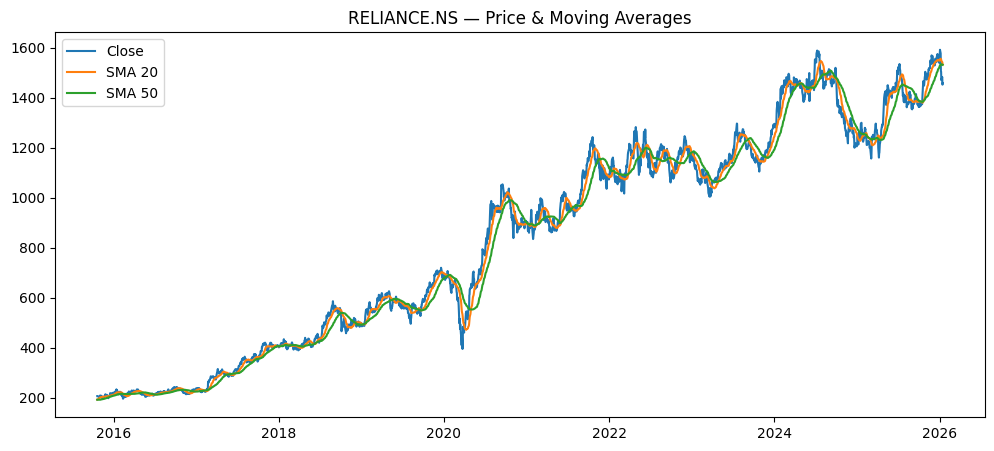

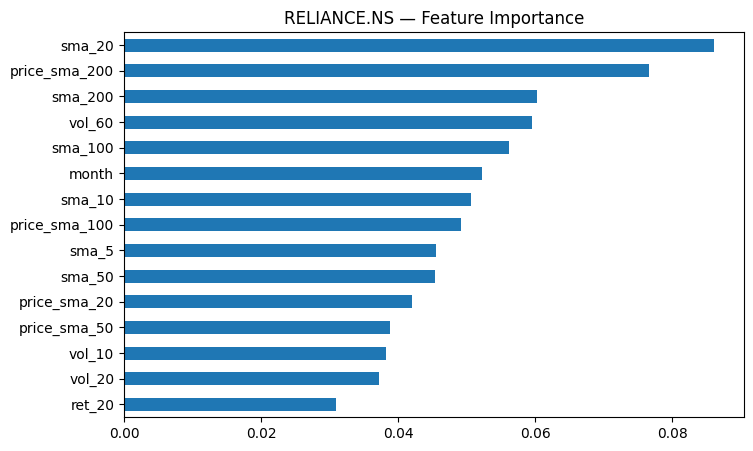

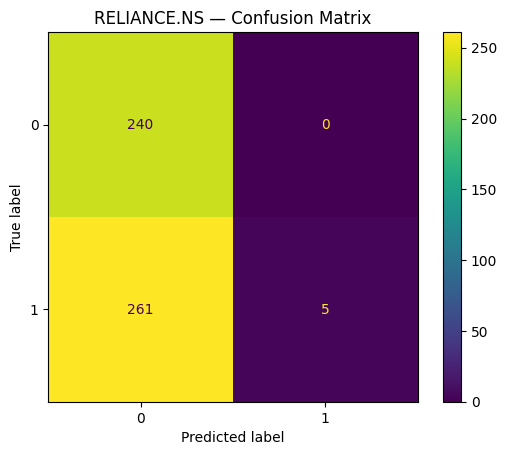

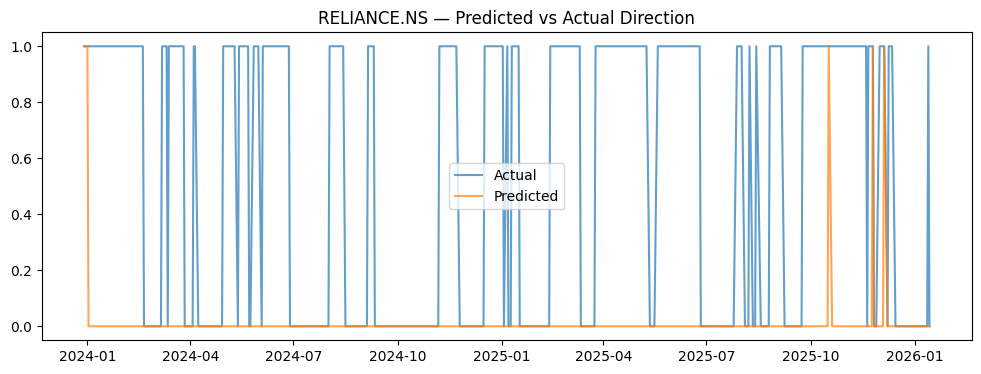

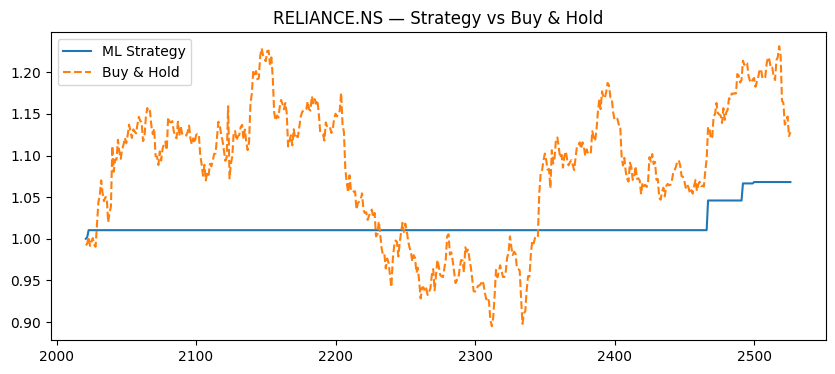


PROCESSING TICKER: HDFCBANK.NS

 WALK-FORWARD VALIDATION

--- Fold 1 ---
              precision    recall  f1-score   support

           0       0.12      0.04      0.06        82
           1       0.75      0.92      0.82       254

    accuracy                           0.70       336
   macro avg       0.44      0.48      0.44       336
weighted avg       0.60      0.70      0.64       336


--- Fold 2 ---
              precision    recall  f1-score   support

           0       0.60      0.10      0.17       156
           1       0.55      0.94      0.69       180

    accuracy                           0.55       336
   macro avg       0.57      0.52      0.43       336
weighted avg       0.57      0.55      0.45       336


--- Fold 3 ---
              precision    recall  f1-score   support

           0       0.52      0.41      0.46       160
           1       0.55      0.66      0.60       176

    accuracy                           0.54       336
   macro avg       0.5

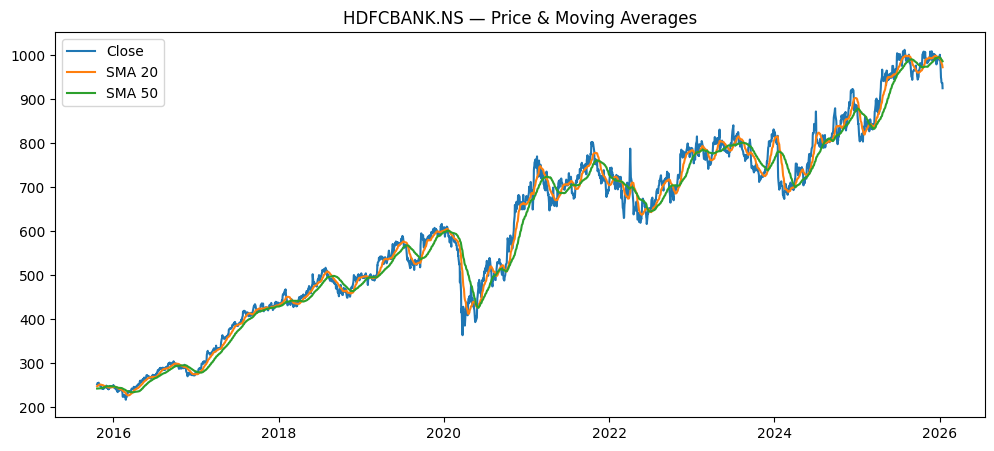

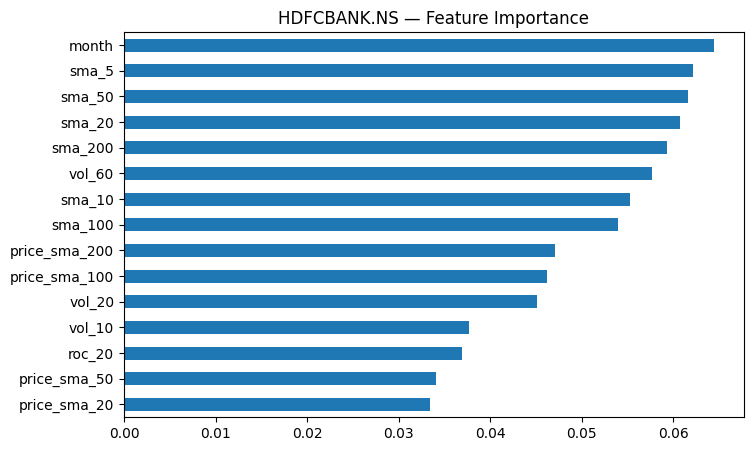

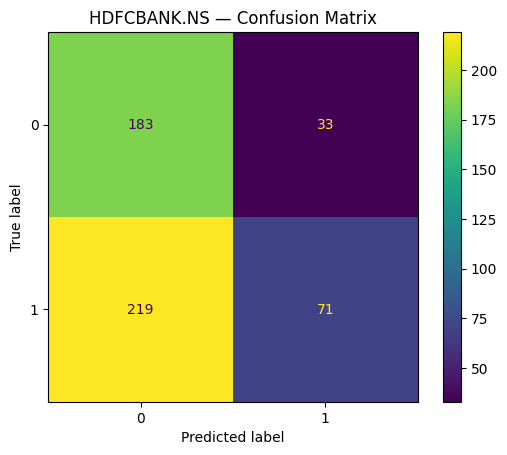

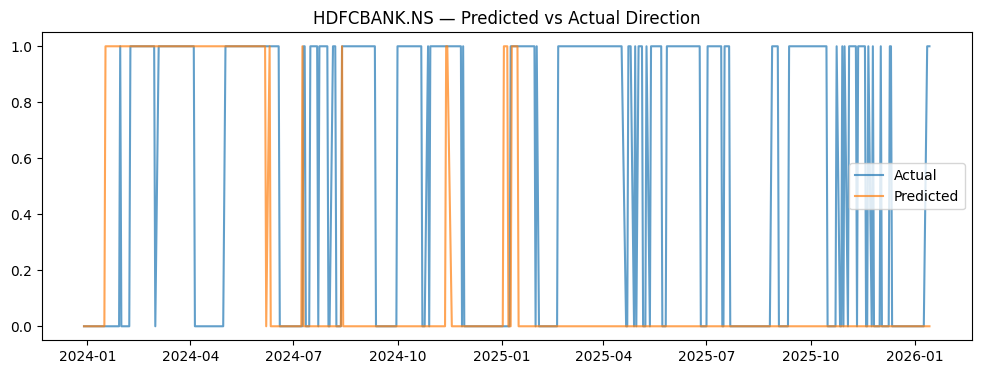

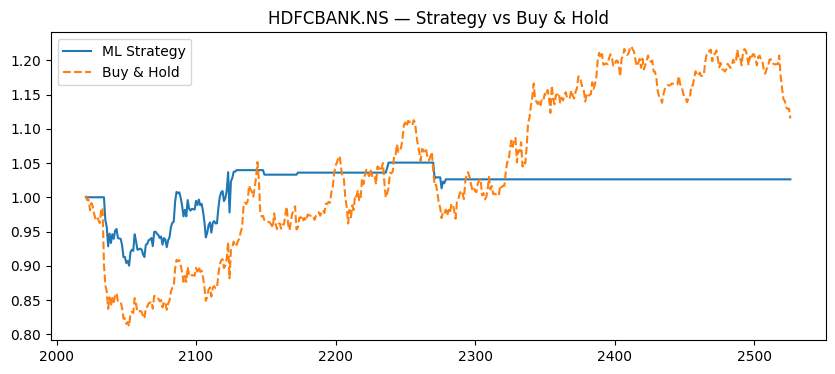


PROCESSING TICKER: INFY.NS

 WALK-FORWARD VALIDATION

--- Fold 1 ---
              precision    recall  f1-score   support

           0       0.38      0.70      0.49        98
           1       0.81      0.53      0.64       238

    accuracy                           0.58       336
   macro avg       0.60      0.61      0.57       336
weighted avg       0.69      0.58      0.60       336


--- Fold 2 ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       153
           1       0.54      1.00      0.71       183

    accuracy                           0.54       336
   macro avg       0.27      0.50      0.35       336
weighted avg       0.30      0.54      0.38       336


--- Fold 3 ---
              precision    recall  f1-score   support

           0       0.32      0.78      0.45        93
           1       0.81      0.35      0.49       243

    accuracy                           0.47       336
   macro avg       0.56   

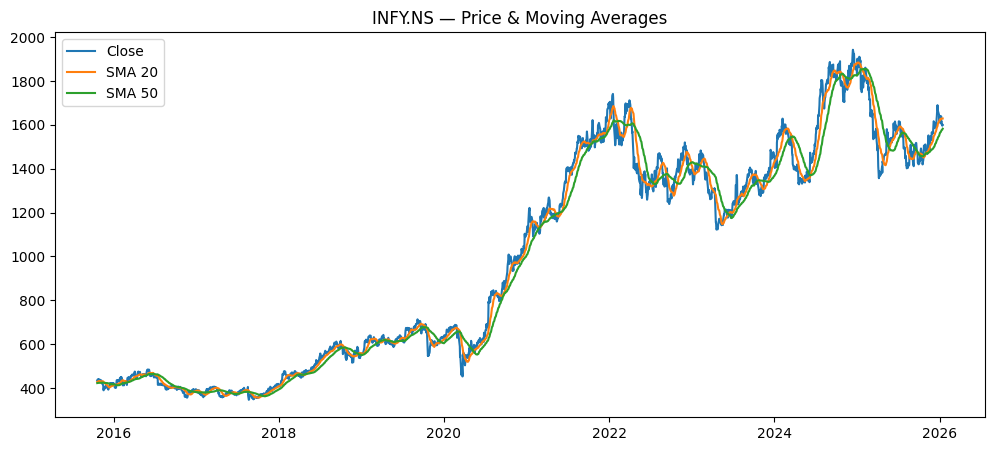

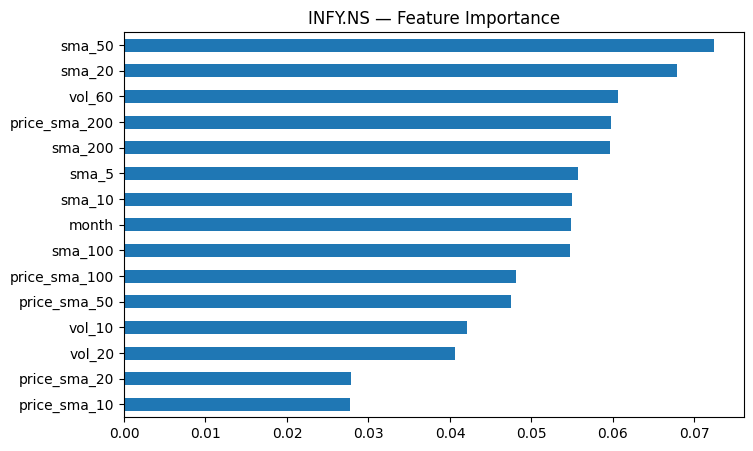

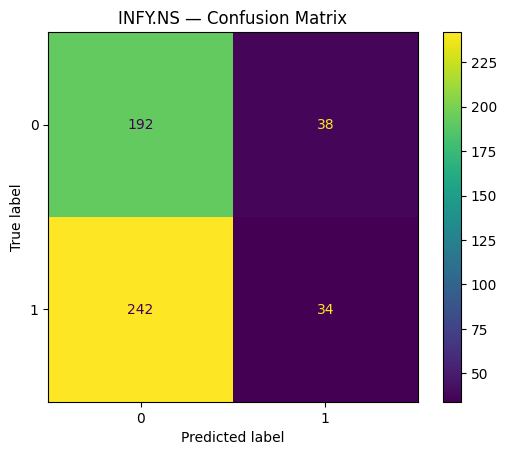

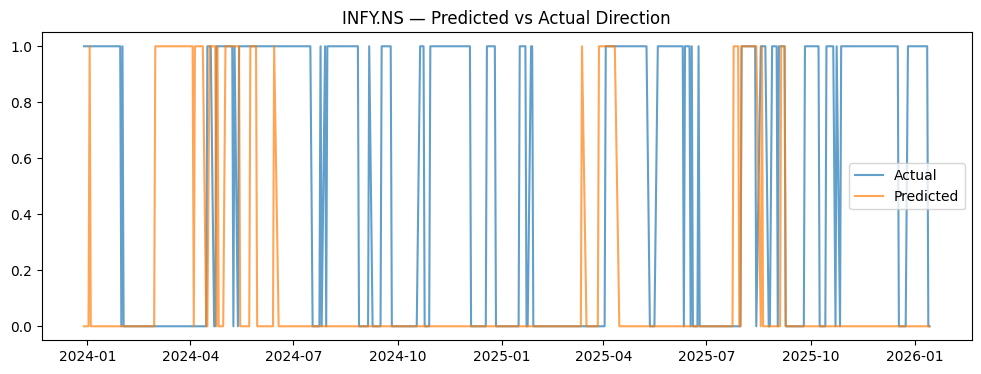

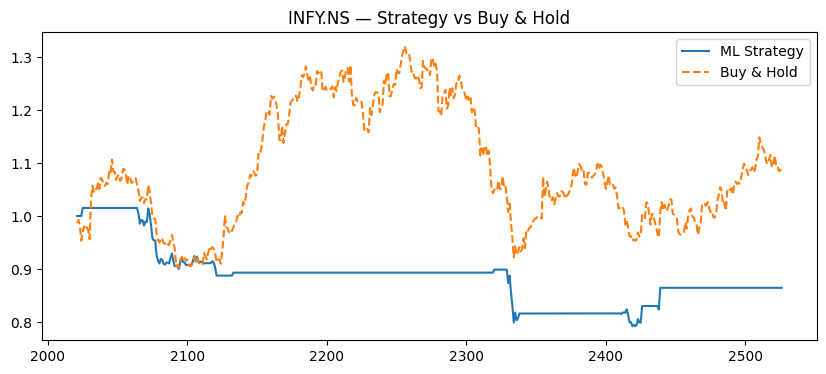

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

# Store final metrics for all tickers
all_results = {}

for ticker in TICKERS:
    print("\n" + "="*80)
    print(f"PROCESSING TICKER: {ticker}")
    print("="*80)

    
    # LOAD PRE-PROCESSED DATA (already saved earlier)
    
    df = pd.read_csv(f"{PROCESSED_DIR}/{ticker}_features.csv", parse_dates=["Date"])

    DROP_COLS = ["Date", "Open", "High", "Low", "Close", "target"]
    X = df.drop(columns=DROP_COLS)
    y = df["target"]

    
    # TRAIN / TEST SPLIT
    
    split_idx = int(len(df) * TRAIN_RATIO)

    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    df_train = df.iloc[:split_idx].copy()
    df_test = df.iloc[split_idx:].copy()

    
    #  WALK-FORWARD CV (TRAIN ONLY)
    
    print("\n WALK-FORWARD VALIDATION")

    tscv = TimeSeriesSplit(n_splits=N_SPLITS)
    cv_metrics = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"\n--- Fold {fold} ---")

        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = get_xgb_model()
        model.fit(X_tr, y_tr)

        val_preds = model.predict(X_val)
        print(classification_report(y_val, val_preds))

        cv_metrics.append({
            "ticker": ticker,
            "fold": fold,
            "accuracy": (val_preds == y_val).mean()
        })

    cv_df = pd.DataFrame(cv_metrics)
    cv_df.to_csv(f"{RESULTS_DIR}/{ticker}_cv_metrics.csv", index=False)

    
    #  FINAL MODEL (FULL TRAIN)
    
    print("\n FINAL TEST PERFORMANCE")

    final_model = get_xgb_model()
    final_model.fit(X_train, y_train)

    test_preds = final_model.predict(X_test)
    print(classification_report(y_test, test_preds))

    
    #  SAVE PREDICTIONS
    
    df_test["prediction"] = test_preds
    df_test["actual"] = y_test.values

    df_test.to_csv(f"{RESULTS_DIR}/{ticker}_predictions.csv", index=False)

    
    #  BACKTEST (TEST ONLY)
    
    df_bt = backtest_strategy(
        df_test,
        pd.Series(test_preds, index=df_test.index)
    )

    df_bt.to_csv(f"{RESULTS_DIR}/{ticker}_backtest.csv", index=False)

    sharpe = sharpe_ratio(df_bt["strategy_ret"].dropna())
    mdd = max_drawdown(df_bt["equity_curve"])
    total_ret = df_bt["equity_curve"].iloc[-1] - 1

    print(f"Sharpe: {sharpe:.3f}")
    print(f"Max Drawdown: {mdd:.3f}")
    print(f"Total Return: {total_ret:.3f}")

    
    # PRICE + FEATURES PLOT
    
    plt.figure(figsize=(12,5))
    plt.plot(df["Date"], df["Close"], label="Close")
    plt.plot(df["Date"], df["sma_20"], label="SMA 20")
    plt.plot(df["Date"], df["sma_50"], label="SMA 50")
    plt.title(f"{ticker} — Price & Moving Averages")
    plt.legend()
    plt.show()

    
    # FEATURE IMPORTANCE
    
    fi = pd.Series(
        final_model.feature_importances_,
        index=X_train.columns
    ).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    fi.head(15).plot(kind="barh")
    plt.title(f"{ticker} — Feature Importance")
    plt.gca().invert_yaxis()
    plt.show()

    
    #  CONFUSION MATRIX
    
    ConfusionMatrixDisplay.from_predictions(y_test, test_preds)
    plt.title(f"{ticker} — Confusion Matrix")
    plt.show()

    
    #  PREDICTED VS ACTUAL
    
    plt.figure(figsize=(12,4))
    plt.plot(df_test["Date"], df_test["actual"], label="Actual", alpha=0.7)
    plt.plot(df_test["Date"], df_test["prediction"], label="Predicted", alpha=0.7)
    plt.title(f"{ticker} — Predicted vs Actual Direction")
    plt.legend()
    plt.show()

    
    #  EQUITY CURVE
    
    plt.figure(figsize=(10,4))
    plt.plot(df_bt["equity_curve"], label="ML Strategy")
    plt.plot((1 + df_test["ret_1"]).cumprod(), "--", label="Buy & Hold")
    plt.title(f"{ticker} — Strategy vs Buy & Hold")
    plt.legend()
    plt.show()

    
    # SAVE FINAL METRICS
    
    all_results[ticker] = {
        "Sharpe": sharpe,
        "MaxDrawdown": mdd,
        "TotalReturn": total_ret
    }


# Aggregated Performance Metrics
This cell consolidates final backtest results across all tickers into a single table.

# Metrics included
    Sharpe Ratio (risk-adjusted return)
    Maximum Drawdown (risk)
    Total Return (profitability)

The summary enables quick cross-asset comparison and highlights that:

Performance varies significantly by stock

No single model works best for all assets

In [8]:
results_df = pd.DataFrame(all_results).T
results_df


,Sharpe,MaxDrawdown,TotalReturn
RELIANCE.NS,1.144414,0.000000,0.068183
HDFCBANK.NS,0.178428,-0.099805,0.026185
INFY.NS,-0.757280,-0.219814,-0.135356


# Limitations & Risks
    Transaction costs and slippage ignored
    Regime shifts not explicitly modeled
    Direction only (no position sizing)
    Potential overfitting in non-linear models

# Possible Improvements

    Add volume, macro, and regime features
    Ensemble Logistic + XGBoost
    Probability-based position sizing
    LSTM / Transformer for sequence learning
    Live data pipeline with rolling retraining